In [221]:
##GENERAL
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import csv
import re
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

##SKLEARN
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange

In [222]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


##Loading in the data

In [223]:
data = pd.read_csv('/gdrive/My Drive/data/amazon_products.csv')
data = data.drop(columns=['Unnamed: 0'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58828 entries, 0 to 58827
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           58828 non-null  object
 1   clean_review     58828 non-null  object
 2   review_category  58828 non-null  object
 3   topic_category   58828 non-null  int64 
 4   topic_name       58828 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [224]:
data['topic_name'].unique()

array(['books', 'video-quality', 'refund-and-return', 'movies', 'music',
       'games'], dtype=object)

##Creating the Text to Categorical Columns

In [225]:
data['topic_name']=data['topic_name'].astype('category')
data['topic_name'].cat.categories
print(data['topic_name'].cat.categories)
data['topic_category_codes']=data['topic_name'].cat.codes.values
data = data.drop(columns=['review','review_category','topic_category','topic_name'])
data.head()

Index(['books', 'games', 'movies', 'music', 'refund-and-return',
       'video-quality'],
      dtype='object')


,clean_review,topic_category_codes
0,this self published book want know read paragr...,0
1,rather scratches insect droppings random pixel...,5
2,my experience got fm Amazon the dvd player rat...,5
3,ordered dvd received substitute received dvd o...,5
4,disappointed performance it underpowered const...,4


##Tokeinze the data using distilBERT Embeddings and distilBERT pre-trained model

In [226]:
data=data.iloc[:,:]

In [227]:
data['topic_category_codes'].value_counts()

4    23020
0    16273
3     7768
5     5203
2     4855
1     1709
Name: topic_category_codes, dtype: int64

In [228]:
data.to_csv('/gdrive/My Drive/data/pytorch_amazon_products_bert.csv')

In [229]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model.cuda()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [230]:

tokenized = data['clean_review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = [len(sent) for sent in tokenized]
max_len = max(max_len)
padded = pad_sequences(tokenized, maxlen=75, padding='post', truncating="post", dtype='long')
print('Shape of data tensor:', padded.shape)
attention_mask = np.where(padded != 0, 1, 0)
print('Shape of attention:', attention_mask.shape)

Shape of data tensor: (58828, 75)
Shape of attention: (58828, 75)


In [231]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [232]:
labels= data.iloc[:,1].values


## Creating the Traning, Test and Attention Mask

In [233]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(padded, labels, 
                                                            random_state=2018, test_size=0.1, stratify=data.topic_category_codes.values)
train_masks, validation_masks, _, _ = train_test_split(attention_mask, padded,
                                             random_state=2018, test_size=0.1, stratify=data.topic_category_codes.values)

In [234]:
train_inputs

array([[  101,  4299,  2246, ...,     0,     0,     0],
       [  101,  6823,  1055, ...,     0,     0,     0],
       [  101,  2310,  4149, ...,     0,     0,     0],
       ...,
       [  101,  2137, 10282, ...,     0,     0,     0],
       [  101,  3728,  2657, ...,     0,     0,     0],
       [  101,  2045,  2503, ...,     0,     0,     0]])

In [235]:
train_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [236]:
np.bincount(train_labels)

array([14646,  1538,  4369,  6991, 20718,  4683])

In [237]:
np.bincount(validation_labels)

array([1627,  171,  486,  777, 2302,  520])

## Creating Dataloader objects 

In [238]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [239]:
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [240]:
train_dataloader

In [241]:
model.parameters()

<generator object Module.parameters at 0x7fb9f01661a8>

## Using Transfer Learning to convert Bert Tokens to Embeddings

- Use only the embedding for [CLS] token which according to the original paper is an aggregate representation of the whole sentence used for classification tasks.

In [242]:
features = []
features_labels = []
for batch in train_dataloader:
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    last_hidden_states = model(b_input_ids, attention_mask=b_input_mask)
    last_hidden_states= last_hidden_states[0][:,0,:].cpu().numpy()
    features.append(last_hidden_states)
    features_labels.append(b_labels.cpu().numpy())
    

In [243]:
features_labels = np.asarray(features_labels)
features_labels_list = [a for a in features_labels]
features_labels = np.concatenate(features_labels_list, axis=0)
features_labels.shape

(52945,)

In [244]:
features = np.asarray(features)
feature_list = [a for a in features]
features = np.concatenate(feature_list, axis=0)
features.shape

(52945, 768)

## Creating a Multi Classification Model using BERT Embedding for Sentence

In [245]:
model = Sequential()
model.add(Dense(768, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=None), input_shape=(768,)))
#model.add(Dropout(0.5))
model.add(Dense(39,kernel_initializer=tf.keras.initializers.glorot_normal(seed=None), activation='relu'))
model.add(Dense(19,kernel_initializer=tf.keras.initializers.glorot_normal(seed=None), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 768)               590592    
_________________________________________________________________
dense_17 (Dense)             (None, 39)                29991     
_________________________________________________________________
dense_18 (Dense)             (None, 19)                760       
_________________________________________________________________
batch_normalization_4 (Batch (None, 19)                76        
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 120       
Total params: 621,539
Trainable params: 621,501
Non-trainable params: 38
_________________________________________________________________


## Training the Classification Model 

In [246]:
import keras
from keras import optimizers
rms = keras.optimizers.RMSprop(lr=0.01, rho=0.9)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [247]:
X_train, X_val, y_train, y_val = train_test_split(features, 
                                                  features_labels, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=features_labels)


In [248]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/models/amazon_bert.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [249]:
model.fit(X_train, y_train, 
          batch_size=32, epochs=100, verbose=1,
          callbacks=callbacks,
          validation_data=(X_val, y_val))

Epoch 1/100
1391/1407 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8681
Epoch 00001: val_loss improved from inf to 0.40775, saving model to /content/drive/My Drive/models/amazon_bert.h5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4461 - accuracy: 0.8683 - val_loss: 0.4078 - val_accuracy: 0.8611
Epoch 2/100
1391/1407 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8944
Epoch 00002: val_loss did not improve from 0.40775
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3329 - accuracy: 0.8944 - val_loss: 0.4446 - val_accuracy: 0.8685
Epoch 3/100
1393/1407 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8997
Epoch 00003: val_loss improved from 0.40775 to 0.33981, saving model to /content/drive/My Drive/models/amazon_bert.h5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3084 - accuracy: 0.8998 - val_loss: 0.3398 - val_accuracy: 0.8850
Epoch 4/100
1396/1407

## Evaluating Model Performance

In [250]:
y_hat = model.predict(X_val)
y_hat = np.argmax(y_hat, axis=1)

In [251]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[2072    2   25   19   69   10]
 [   8  191    1    6   20    5]
 [  19    0  562    7   20   47]
 [  23    1    3  963   47   12]
 [  96   10   25   46 2891   40]
 [   8    3   35   25   29  602]]


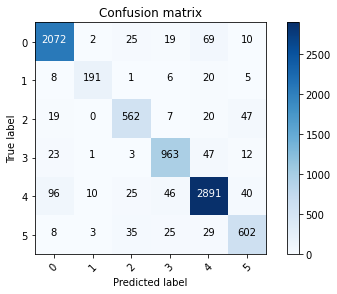

In [252]:
cm = confusion_matrix(y_val, y_hat)
plot_confusion_matrix(cm, [0,1,2,3,4,5])